In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from datetime import timedelta
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df_before = pd.read_csv('CR_FC_PREP_0522.csv')
df_before['POD'] = pd.to_datetime(df_before['POD'])

df_before.head()
df_before.tail()
df_before.info()
print(f'Dataset size: {df_before.shape}')


,POD,RATE
0,2005-07-19,2200.0
1,2005-07-20,2250.0
2,2005-07-21,2300.0
3,2005-07-22,2280.0
4,2005-07-23,2260.0


,POD,RATE
6370,2022-12-27,4121.43
6371,2022-12-28,4142.86
6372,2022-12-29,4164.29
6373,2022-12-30,4185.71
6374,2022-12-31,4207.14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6375 entries, 0 to 6374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6375 non-null   datetime64[ns]
 1   RATE    6375 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 99.7 KB
Dataset size: (6375, 2)


In [83]:
def FindANOMALY(df):

    # Isolation Forest Algo
    clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, random_state=42)

    # Train the algorithm
    clf.fit(df[['RATE']])

    # Predict anomalies
    df['ANOMALY'] = clf.predict(df[['RATE']])

    # Create a new dataframe for the anomalies
    is_anomaly = df[df['ANOMALY'] == -1].reset_index(drop=True)

    # Plot the data
    plt.plot(df['POD'], df['RATE'], color='blue', label='All Rates')
    plt.plot(is_anomaly['POD'], is_anomaly['RATE'], color='red', label='Anomaly Rates')

    # Add axis labels and legend
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.legend()

    # Show the plot
    plt.show()

    return df

c:\Users\it1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


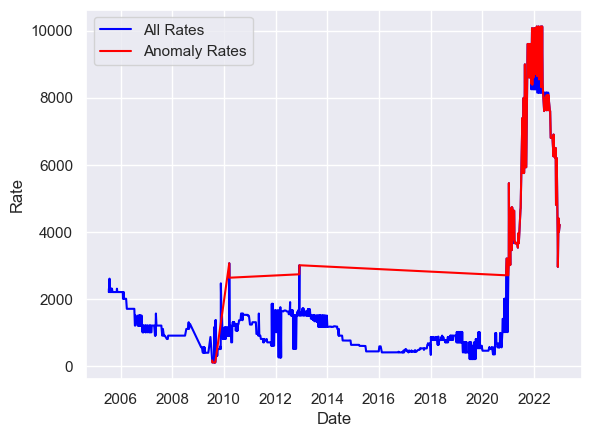

,POD,RATE,ANOMALY
0,2005-07-19,2200.0,1
1,2005-07-20,2250.0,1
2,2005-07-21,2300.0,1
3,2005-07-22,2280.0,1
4,2005-07-23,2260.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6375 entries, 0 to 6374
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   POD      6375 non-null   datetime64[ns]
 1   RATE     6375 non-null   float64       
 2   ANOMALY  6375 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 124.6 KB


In [84]:
is_anomaly = FindANOMALY(df_before)
is_anomaly.head()
is_anomaly.info()

In [85]:
# Removing annomly
rows_to_drop1 = is_anomaly.loc[is_anomaly['ANOMALY'] == -1].index

# Removing values from 2022 to 2023 based on POD column
rows_to_drop2 = df_before[(df_before['POD'] >= '2022-03-11') & (df_before['POD'] < '2024-01-01')].index

# Combine the rows to drop
rows_to_drop = rows_to_drop1.union(rows_to_drop2)

# Remove the selected rows
df_before = df_before.drop(rows_to_drop).reset_index(drop=True)

# Print information about the modified dataframe
df_before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   POD      5665 non-null   datetime64[ns]
 1   RATE     5665 non-null   float64       
 2   ANOMALY  5665 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 110.8 KB


In [86]:
skewness = skew(df_before['RATE'])

# print the skewness value
print("Skewness of RATE column: ", skewness)

# check if the skewness is positive or negative
if skewness > 0:
    print("The RATE column is positively skewed")
elif skewness < 0:
    print("The RATE column is negatively skewed")
else:
    print("The RATE column is symmetric")

Skewness of RATE column:  5.494087952126422
The RATE column is positively skewed


Filling up the missing dates removed by the annomly detection and after WHO declared the pandamic after March 11 2022

In [87]:
# Set the POD column as the index
df_before.set_index('POD', inplace=True)

# Interpolate missing dates in the POD column
df_before = df_before.resample('D').interpolate(method='time')

# Resample to daily frequency and aggregate RATE using mean
df_before = df_before.resample('D').agg({'RATE': 'median'})

# Reset index to have POD as a column again
df_before = df_before.reset_index()

# Making Rate as a float in 2dp
df_before['RATE'] = df_before['RATE'].round(2).astype(float)

# Print the resulting dataframe
df_before.head()
df_before.tail()
df_before.info()

,POD,RATE
0,2005-07-19,2200.0
1,2005-07-20,2250.0
2,2005-07-21,2300.0
3,2005-07-22,2280.0
4,2005-07-23,2260.0


,POD,RATE
6071,2022-03-03,8150.0
6072,2022-03-04,8150.0
6073,2022-03-05,8150.0
6074,2022-03-06,8150.0
6075,2022-03-07,8150.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6076 entries, 0 to 6075
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6076 non-null   datetime64[ns]
 1   RATE    6076 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 95.1 KB


<Figure size 5000x2000 with 0 Axes>

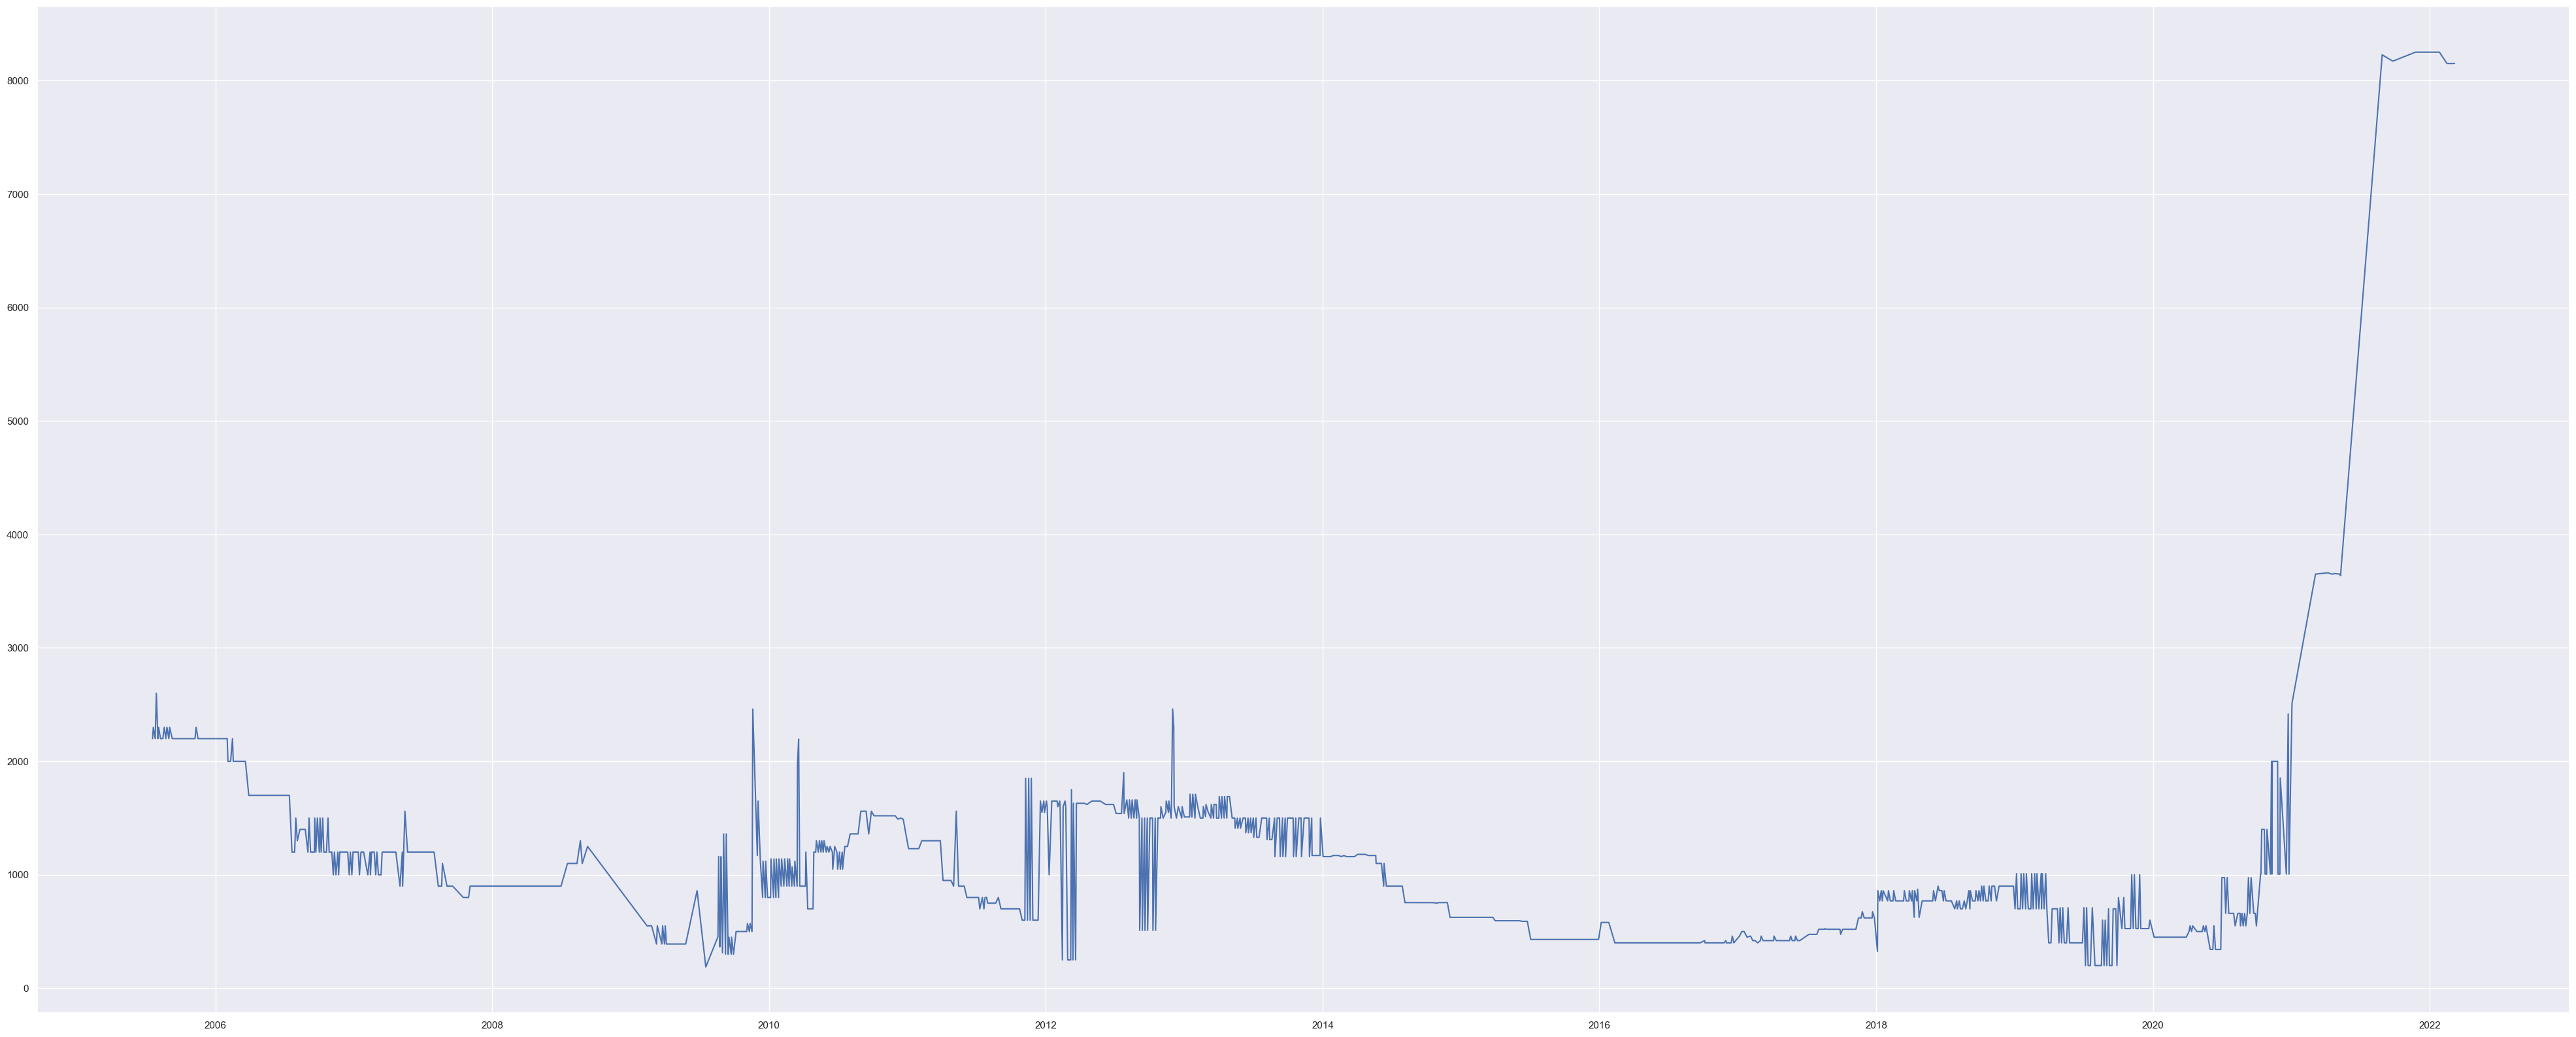

In [88]:
plt.figure(figsize=(50, 20))
plt.plot(df_before['POD'], df_before['RATE'])
plt.show()

In [89]:
# After 2023 data to compare accuracy of forecast
df_after = pd.read_csv('CR_FC_PREP_23.csv')
df_after['POD'] = pd.to_datetime(df_after['POD'])

# df_after.set_index('POD',inplace=True)

df_after.head()
df_after.tail()
df_after.info()
print(f'Dataset size: {df_after.shape}')

,POD,RATE
0,2023-01-01,4228.57
1,2023-01-02,4250.00
2,2023-01-03,2800.00
3,2023-01-04,2800.00
4,2023-01-05,2800.00


,POD,RATE
47,2023-02-17,1500.0
48,2023-02-18,1500.0
49,2023-02-19,1500.0
50,2023-02-20,1500.0
51,2023-02-21,1500.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     52 non-null     datetime64[ns]
 1   RATE    52 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 960.0 bytes
Dataset size: (52, 2)


In [92]:
df_before_last = df_before.iloc[-1]['POD']
df_after_first = df_after.iloc[0]['POD']
print(df_before_last,df_after_first)

# Calculate the difference between the two dates in days
diff_days = (df_after_first - df_before_last).days
print(diff_days)

2022-03-07 00:00:00 2023-01-01 00:00:00
300


In [96]:
def newDateFrame(df, n_periods):
    # Create a data frame for the forecast for the next 24 months
    index_of_fc = pd.date_range(start=df_before.iloc[-1]['POD'], periods = n_periods+1, freq='D')
    newFrameName = pd.DataFrame(index=index_of_fc[1:],columns=df.columns)
    newFrameName.iloc[1:]
    newFrameName.shape

    return newFrameName

In [97]:
cf = newDateFrame(df_before, diff_days)
cf.head()
cf.tail()
cf.info()

,POD,RATE
2023-01-01,NaN,NaN
2023-01-02,NaN,NaN
2023-01-03,NaN,NaN
2023-01-04,NaN,NaN
2023-01-05,NaN,NaN


,POD,RATE
2023-10-23,NaN,NaN
2023-10-24,NaN,NaN
2023-10-25,NaN,NaN
2023-10-26,NaN,NaN
2023-10-27,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2023-01-01 to 2023-10-27
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   POD     0 non-null      object
 1   RATE    0 non-null      object
dtypes: object(2)
memory usage: 7.0+ KB


In [ ]:
# From actual dataset after 2023 convert for forecasting
actual_X = df_after.drop("RATE", axis=1)
actual_y = df_after["RATE"]

# Dataset before 2023 convert for forecasting
Y = df_before.pop('RATE') 
X = df_before

#normalise
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
def findRF(X_train, X_test, y_train, y_test):
    # Build the random forest model
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)

    # Predict the test data
    rf_y_pred = rf_model.predict(X_test)

    # Calculate the root mean squared error
    rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
    
    # Calculate the R-squared value
    r2 = r2_score(y_test, rf_y_pred)

    # Calculate the accuracy score in percentage
    mean = y_test.mean()
    accuracy = (1 - rmse/mean) * 100

    print("Root Mean Squared Error:", round(rmse, 3))
    print("R-squared Value:", round(r2, 3))
    print("Accuracy Score:", round(accuracy, 2), "%")

    return rf_y_pred

In [ ]:
def findDT(X_train, X_test, y_train, y_test):
    # Train the model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

    # Make predictions on test data
    dt_y_pred = model.predict(X_test)

    # Calculate mean squared error between actual and predicted values
    mse = mean_squared_error(y_test, dt_y_pred)

    # Calculate root mean squared error
    rmse = np.sqrt(mse)

    # Calculate R-squared value
    r2 = r2_score(y_test, dt_y_pred)

    # Calculate mean value of your actual data
    mean = np.mean(y_test)

    # Calculate accuracy of your model in percentage
    accuracy = (1 - rmse/mean) * 100

    print('Root Mean Squared Error:', round(rmse, 3))
    print('R-squared:', round(r2, 3))
    print(f"Accuracy: {accuracy:.2f}%")

    return dt_y_pred

In [ ]:
def findACC(y_pred, actual_y):
    # Calculate the accuracy of the model using mean absolute error and R-squared
   mae = mean_absolute_error(y_pred, actual_y)
   r2 = r2_score(y_pred, actual_y)

   print(f"Mean absolute error: {mae:.4f}")
   print(f"R-squared value: {r2:.4f}")

In [ ]:
n_periods = 52

# Random Forest
print("Random Forest Regressor")
rf_y_pred = findRF(X_train, X_test, y_train, y_test)[-n_periods:]
print(rf_y_pred)
print("\n")

# Decision Tree
print("Decision Tree Regressor:")
dt_y_pred = findRF(X_train, X_test, y_train, y_test)[-n_periods:]
print(dt_y_pred)
print("\n")

In [ ]:
# Random Forest
print("Random forest regressor forecast vs actual cost rate results:")
findACC(rf_y_pred, actual_y)
print("\n")

# Decision Tree
print("Decision tree regressor forecast vs actual cost rate results:")
findACC(dt_y_pred, actual_y)
print("\n")


In [ ]:
# # Plot the forecast with current dataset
# plt.figure(figsize=(30, 8))
# plt.plot(df_bf_indexed)
# plt.plot(forecast_df, color='darkgreen')
# plt.title("Final Forecast of COST_RATE")
# plt.show()